<a href="https://colab.research.google.com/github/ganeshkumar269/colabnotebooks/blob/main/miniproject_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras==2.3.0

In [ ]:
!pip install tensorflow==1.15
!pip install tensorflow-gpu==1.15

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
path_base = '/content/gdrive/My Drive/ISIC-2017-Org-Train-Data/'

In [ ]:
import tensorflow as tf

In [ ]:
#@title Segmentation.py {form-width:"50px"}
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from keras.optimizers import Adam
import os
 
import warnings
import numpy as np
import cv2
import keras.backend as K
from keras.models import Model
from keras import layers
from keras.layers import Input
from keras.layers import Activation
from keras.layers import Dense
from keras.layers import Concatenate
from keras.layers import Softmax, Reshape
from keras.layers import Dropout, concatenate, ConvLSTM2D
from keras.layers import BatchNormalization
from keras.layers import Conv2D, Dense, multiply, concatenate, Conv3D
from keras.layers import SeparableConv2D
from keras.layers import MaxPooling2D
from keras.layers import DepthwiseConv2D
from keras.layers import ZeroPadding2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import AveragePooling2D
from keras.engine import Layer
from keras.engine import InputSpec
from keras.engine.topology import get_source_inputs
from keras import backend as K
from keras.applications import imagenet_utils
from keras.utils import conv_utils
import keras
from keras.layers.core import Lambda
from keras.utils.data_utils import get_file
from keras.layers import Add
 
 
TF_WEIGHTS_PATH = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5"
class BilinearUpsampling(Layer):
    """Just a simple bilinear upsampling layer. Works only with TF.
       Args:
           upsampling: tuple of 2 numbers > 0. The upsampling ratio for h and w
           output_size: used instead of upsampling arg if passed!
    """
 
    def __init__(self, upsampling=(2, 2), output_size=None, l_name = None, data_format=None, **kwargs):
 
        super(BilinearUpsampling, self).__init__(**kwargs)
 
        self.data_format = normalize_data_format(data_format)
        self.name = l_name
        self.input_spec = InputSpec(ndim=4)
        if output_size:
            self.upsample_size = conv_utils.normalize_tuple(
                output_size, 2, 'size')
            self.upsampling = None
        else:
            self.upsampling = conv_utils.normalize_tuple(upsampling, 2, 'size')
 
    def compute_output_shape(self, input_shape):
        if self.upsampling:
            height = self.upsampling[0] * \
                input_shape[1] if input_shape[1] is not None else None
            width = self.upsampling[1] * \
                input_shape[2] if input_shape[2] is not None else None
        else:
            height = self.upsample_size[0]
            width = self.upsample_size[1]
        return (input_shape[0],
                height,
                width,
                input_shape[3])
 
    def call(self, inputs):
        if self.upsampling:
            return tf.image.resize_bilinear(inputs, (inputs.shape[1] * self.upsampling[0],
                                                       inputs.shape[2] * self.upsampling[1]),
                                              align_corners=True, name = self.name )
        else:
            return tf.image.resize_bilinear(inputs, (self.upsample_size[0],
                                                       self.upsample_size[1]),
                                              align_corners=True, name= self.name )
 
    def get_config(self):
        config = {'size': self.upsampling,
                  'data_format': self.data_format}
        base_config = super(BilinearUpsampling, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
 
 
def SepConv_BN(x, filters, prefix, stride=1, kernel_size=3, rate=1, depth_activation=False, epsilon=1e-3):
    """ SepConv with BN between depthwise & pointwise. Optionally add activation after BN
        Implements right "same" padding for even kernel sizes
        Args:
            x: input tensor
            filters: num of filters in pointwise convolution
            prefix: prefix before name
            stride: stride at depthwise conv
            kernel_size: kernel size for depthwise convolution
            rate: atrous rate for depthwise convolution
            depth_activation: flag to use activation between depthwise & poinwise convs
            epsilon: epsilon to use in BN layer
    """
 
    if stride == 1:
        depth_padding = 'same'
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = ZeroPadding2D((pad_beg, pad_end))(x)
        depth_padding = 'valid'
 
    if not depth_activation:
        x = Activation('relu')(x)
    x = DepthwiseConv2D((kernel_size, kernel_size), strides=(stride, stride), dilation_rate=(rate, rate),
                        padding=depth_padding, use_bias=False, name=prefix + '_depthwise')(x)
    x = BatchNormalization(name=prefix + '_depthwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = Activation('relu')(x)
    x = Conv2D(filters, (1, 1), padding='same',
               use_bias=False, name=prefix + '_pointwise')(x)
    x = BatchNormalization(name=prefix + '_pointwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = Activation('relu')(x)
 
    return x
 
 
def conv2d_same(x, filters, prefix, stride=1, kernel_size=3, rate=1):
    """Implements right 'same' padding for even kernel sizes
        Without this there is a 1 pixel drift when stride = 2
        Args:
            x: input tensor
            filters: num of filters in pointwise convolution
            prefix: prefix before name
            stride: stride at depthwise conv
            kernel_size: kernel size for depthwise convolution
            rate: atrous rate for depthwise convolution
    """
    if stride == 1:
        return Conv2D(filters,
                      (kernel_size, kernel_size),
                      strides=(stride, stride),
                      padding='same', use_bias=False,
                      dilation_rate=(rate, rate),
                      name=prefix)(x)
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = ZeroPadding2D((pad_beg, pad_end))(x)
        return Conv2D(filters,
                      (kernel_size, kernel_size),
                      strides=(stride, stride),
                      padding='valid', use_bias=False,
                      dilation_rate=(rate, rate),
                      name=prefix)(x)
 
 
def xception_block(inputs, depth_list, prefix, skip_connection_type, stride,
                   rate=1, depth_activation=False, return_skip=False):
    """ Basic building block of modified Xception network
        Args:
            inputs: input tensor
            depth_list: number of filters in each SepConv layer. len(depth_list) == 3
            prefix: prefix before name
            skip_connection_type: one of {'conv','sum','none'}
            stride: stride at last depthwise conv
            rate: atrous rate for depthwise convolution
            depth_activation: flag to use activation between depthwise & pointwise convs
            return_skip: flag to return additional tensor after 2 SepConvs for decoder
            """
    residual = inputs
    for i in range(3):
        residual = SepConv_BN(residual,
                              depth_list[i],
                              prefix + '_separable_conv{}'.format(i + 1),
                              stride=stride if i == 2 else 1,
                              rate=rate,
                              depth_activation=depth_activation)
        if i == 1:
            skip = residual
    if skip_connection_type == 'conv':
        shortcut = conv2d_same(inputs, depth_list[-1], prefix + '_shortcut',
                               kernel_size=1,
                               stride=stride)
        shortcut = BatchNormalization(name=prefix + '_shortcut_BN')(shortcut)
        outputs = layers.add([residual, shortcut])
    elif skip_connection_type == 'sum':
        outputs = layers.add([residual, inputs])
    elif skip_connection_type == 'none':
        outputs = residual
    if return_skip:
        return outputs, skip
    else:
        return outputs
   
def Deeplabv3pa(weights='pascal_voc', input_tensor=None, input_shape=(512, 512, 3), classes=21, OS=16):
    if not (weights in {'pascal_voc', None}):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `pascal_voc` '
                         '(pre-trained on PASCAL VOC)')
 
    if K.backend() != 'tensorflow':
        raise RuntimeError('The Deeplabv3+ model is only available with '
                           'the TensorFlow backend.')
 
    if OS == 8:
        entry_block3_stride = 1
        middle_block_rate = 2  # ! Not mentioned in paper, but required
        exit_block_rates = (2, 4)
        atrous_rates = (12, 24, 36)
    else:
        entry_block3_stride = 2
        middle_block_rate = 1
        exit_block_rates = (1, 2)
        atrous_rates = (6, 12, 18)
 
    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
 
    x = Conv2D(32, (3, 3), strides=(2, 2),
               name='entry_flow_conv1_1', use_bias=False, padding='same')(img_input)
    x = BatchNormalization(name='entry_flow_conv1_1_BN')(x)
    x = Activation('relu')(x)
 
    x = conv2d_same(x, 64, 'entry_flow_conv1_2', kernel_size=3, stride=1)
    x = BatchNormalization(name='entry_flow_conv1_2_BN')(x)
    x = Activation('relu')(x)
 
    x = xception_block(x, [128, 128, 128], 'entry_flow_block1',
                       skip_connection_type='conv', stride=2,
                       depth_activation=False)
    x, skip1 = xception_block(x, [256, 256, 256], 'entry_flow_block2',
                              skip_connection_type='conv', stride=2,
                              depth_activation=False, return_skip=True)
 
    x = xception_block(x, [728, 728, 728], 'entry_flow_block3',
                       skip_connection_type='conv', stride=entry_block3_stride,
                       depth_activation=False)
    for i in range(16):
        x = xception_block(x, [728, 728, 728], 'middle_flow_unit_{}'.format(i + 1),
                           skip_connection_type='sum', stride=1, rate=middle_block_rate,
                           depth_activation=False)
 
    x = xception_block(x, [728, 1024, 1024], 'exit_flow_block1',
                       skip_connection_type='conv', stride=1, rate=exit_block_rates[0],
                       depth_activation=False)
    x = xception_block(x, [1536, 1536, 2048], 'exit_flow_block2',
                       skip_connection_type='none', stride=1, rate=exit_block_rates[1],
                       depth_activation=True)
    # end of feature extractor
 
    # branching for Atrous Spatial Pyramid Pooling
    # simple 1x1
    b0 = Conv2D(256, (1, 1), padding='same', use_bias=False, name='aspp0')(x)
    b0 = BatchNormalization(name='aspp0_BN', epsilon=1e-5)(b0)
    b0 = Activation('relu', name='aspp0_activation')(b0)
 
    # rate = 6 (12)
    b1 = SepConv_BN(x, 256, 'aspp1',
                    rate=atrous_rates[0], depth_activation=True, epsilon=1e-5)
    # rate = 12 (24)
    b2 = SepConv_BN(x, 256, 'aspp2',
                    rate=atrous_rates[1], depth_activation=True, epsilon=1e-5)
    # rate = 18 (36)
    b3 = SepConv_BN(x, 256, 'aspp3',
                    rate=atrous_rates[2], depth_activation=True, epsilon=1e-5)
 
    # Image Feature branch
    out_shape = int(np.ceil(input_shape[0] / OS))
    b4 = AveragePooling2D(pool_size=(out_shape, out_shape))(x)
    b4 = Conv2D(256, (1, 1), padding='same',
                use_bias=False, name='image_pooling')(b4)
    b4 = BatchNormalization(name='image_pooling_BN', epsilon=1e-5)(b4)
    b4 = Activation('relu')(b4)
    b4 = BilinearUpsampling((out_shape, out_shape), l_name = 'up1')(b4)
    b0_1 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b0)    
    b0_1 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b0_1)
    b0_1 = Dropout(0.5)(b0_1)
    b0_c = concatenate([b0, b0_1], axis = 3)
    b0_2 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b0_c)    
    b0   = Conv2D(256, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b0_2)    
 
    # b1
    b1_1 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b1)    
    b1_1 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b1_1)
    b1_1 = Dropout(0.5)(b1_1)
    b1_c = concatenate([b1, b1_1], axis = 3)
    b1_2 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b1_c)    
    b1   = Conv2D(256, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b1_2)  
            
    # b2
    b2_1 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b2)    
    b2_1 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b2_1)
    b2_1 = Dropout(0.5)(b2_1)
    b2_c = concatenate([b2, b2_1], axis = 3)
    b2_2 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b2_c)    
    b2   = Conv2D(256, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b2_2)  
    
    # b3
    b3_1 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b3)    
    b3_1 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b3_1)
    b3_1 = Dropout(0.5)(b3_1)
    b3_c = concatenate([b3, b3_1], axis = 3)
    b3_2 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b3_c)    
    b3   = Conv2D(256, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b3_2)  
    
    # b4
    b4_1 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b4)    
    b4_1 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b4_1)
    b4_1 = Dropout(0.5)(b4_1)
    b4_c = concatenate([b4, b4_1], axis = 3)
    b4_2 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b4_c)    
    b4   = Conv2D(256, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b4_2)  
    Dense0 = Dense(256, activation='relu',    kernel_initializer='he_normal', use_bias=False)
    Dense1 = Dense(32 , activation='relu',    kernel_initializer='he_normal', use_bias=False)
    Dense2 = Dense(256, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)
    
    b0_1 = Reshape((1, 1, 256))(GlobalAveragePooling2D()(b0))
    b0_1 = Dense2(Dense1(Dense0(b0_1)))
 
    b1_1 = Reshape((1, 1, 256))(GlobalAveragePooling2D()(b1))
    b1_1 = Dense2(Dense1(Dense0(b1_1)))
    
    b2_1 = Reshape((1, 1, 256))(GlobalAveragePooling2D()(b2))
    b2_1 = Dense2(Dense1(Dense0(b2_1)))
    
    b3_1 = Reshape((1, 1, 256))(GlobalAveragePooling2D()(b3))
    b3_1 = Dense2(Dense1(Dense0(b3_1)))
 
    b4_1 = Reshape((1, 1, 256))(GlobalAveragePooling2D()(b4))
    b4_1 = Dense2(Dense1(Dense0(b4_1)))
    
    x0 = multiply([b0, b0_1])                
    x1 = multiply([b1, b1_1])
    x2 = multiply([b2, b2_1])
    x3 = multiply([b3, b3_1])
    x4 = multiply([b4, b4_1])
    
    x0 = Reshape((16, 16, 1, 256))(x0)
    x1 = Reshape((16, 16, 1, 256))(x1)
    x2 = Reshape((16, 16, 1, 256))(x2)
    x3 = Reshape((16, 16, 1, 256))(x3)
    x4 = Reshape((16, 16, 1, 256))(x4)
    x  = Concatenate(axis=3)([x0, x1, x2, x3, x4])
    x  = Conv3D(256, (1,1,5), activation='relu', use_bias=False, kernel_initializer='he_normal')(x)
    x  = Reshape((16, 16, 256))(x)
    x  = Conv2D(256, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x) 
    x  = Conv2D(256, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)     
    x = BatchNormalization(name='concat_projection_BN', epsilon=1e-5)(x)
    x = Activation('relu')(x)
    x = Dropout(0.1)(x)
    # DeepLab v.3+ decoder
 
    # Feature projection
 
    x = BilinearUpsampling(output_size=(int(np.ceil(input_shape[0] / 4)),
                                        int(np.ceil(input_shape[1] / 4))), l_name = 'up2')(x)
    dec_skip1 = Conv2D(48, (1, 1), padding='same',
                       use_bias=False, name='feature_projection0')(skip1)
    dec_skip1 = BatchNormalization(
        name='feature_projection0_BN', epsilon=1e-5)(dec_skip1)
    dec_skip1 = Activation('relu')(dec_skip1)
    x = Concatenate()([x, dec_skip1])
    x = SepConv_BN(x, 256, 'decoder_conv0',
                   depth_activation=True, epsilon=1e-5)
    x = SepConv_BN(x, 256, 'decoder_conv1',
                   depth_activation=True, epsilon=1e-5)
 
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    x = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    x1 = BilinearUpsampling(output_size=(input_shape[0], input_shape[1]), l_name = 'x1')(x)  
 
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
 
    model = Model(inputs, x1, name='deeplabv3+')
 
    # load weights
 
    if weights == 'pascal_voc':
        weights_path = get_file('deeplabv3_weights_tf_dim_ordering_tf_kernels.h5',
                                TF_WEIGHTS_PATH,
                                cache_subdir='models')
        model.load_weights(weights_path, by_name=True)
        
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
 
    return model

Using TensorFlow backend.


In [ ]:
#@title
def normalize_data_format(value):
    if value is None:
        value = K.image_data_format()
    data_format = value.lower()
    if data_format not in {'channels_first', 'channels_last'}:
        raise ValueError('The `data_format` argument must be one of '
                         '"channels_first", "channels_last". Received: ' +
                         str(value))
    return data_format

In [ ]:
def segment(data):
  model = Deeplabv3pa(input_shape = (256, 256, 3))
  model.summary()
  model.load_weights('/content/gdrive/My Drive/deeplabv3_isic2017_weights')
  predictions= model.predict(data,batch_size=8,verbose=1)
  return predictions

In [ ]:
#@title data preprocessingv1 { form-width : "50px" }
from __future__ import division
import numpy as np
import scipy.io as sio
import scipy.misc as sc
import glob
from PIL import Image
import cv2
# Parameters
height = 256
width  = 256
channels = 3

Dataset_add = '/content/gdrive/My Drive/ISIC-2017-Org-Train-Data/After-Enhancement-2/'


Tr_list = glob.glob(Dataset_add + '/*.jpg')

Data_train_2017    = np.zeros([2000, height, width, channels])


print('Reading ISIC 2017')
for idx in range(len(Tr_list)):
    img = cv2.imread(Tr_list[idx])
    img = np.double(img)
    Data_train_2017[idx, :,:,:] = img
    if idx % 100 == 0:
      print(idx,' Completed')
print('Reading ISIC 2017 finished')

Train_img = Data_train_2017[0:2000,:,:,:]
np.save(path_base+'data_val', Train_img)

In [ ]:
#@title data preprocessingv2 { form-width : "50px" }
import csv
import cv2
import numpy as np

csvFile = open('/content/gdrive/MyDrive/ISIC-2017-Org-Train-Data/ISIC-2017_Training_Part3_GroundTruth.csv')
csvReader = csv.reader(csvFile)

csvReader.__next__()

height = 256
width  = 256
channels = 3

Data_train_2017    = np.zeros([2000, height, width, channels])

print('Reading ISIC 2017')
for idx in range(2000):
    img = cv2.imread(path_base + "After-Enhancement-2/" + csvReader.__next__()[0] + ".jpg")
    img = np.double(img)
    Data_train_2017[idx, :,:,:] = img
    if idx % 100 == 0:
      print(idx,' Completed')
print('Reading ISIC 2017 finished')

Train_img = Data_train_2017[0:2000,:,:,:]
np.save(path_base+'data_train_v2', Train_img)


In [ ]:
#@title dataset_normalised {form-width : "50px"}
def dataset_normalized(imgs):
    imgs_normalized = np.empty(imgs.shape)
    imgs_std = np.std(imgs)
    imgs_mean = np.mean(imgs)
    imgs_normalized = (imgs-imgs_mean)/imgs_std
    for i in range(imgs.shape[0]):
        imgs_normalized[i] = ((imgs_normalized[i] - np.min(imgs_normalized[i])) / (np.max(imgs_normalized[i])-np.min(imgs_normalized[i])))*255
    return imgs_normalized

In [ ]:
te_data = np.load(path_base+'data_train_v2.npy')
te_data  = dataset_normalized(te_data)

In [ ]:
predictions = segment(te_data)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

166100992/166096424 [==============================] - 7s 0us/step
Model: "deeplabv3+"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
entry_flow_conv1_1 (Conv2D)     (None, 128, 128, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
entry_flow_conv1_1_BN (BatchNor (None, 128, 128, 32) 128         entry_flow_conv1_1[0][0]         
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 

In [ ]:
np.save(path_base+"predictions_array_v2",predictions)

In [ ]:
import numpy as np

predictions = np.load(path_base+"predictions_array.npy")

In [ ]:
import glob
Dataset_add = '/content/gdrive/My Drive/ISIC-2017-Org-Train-Data/After-Enhancement-2/'

Tr_list = glob.glob(Dataset_add + '/*.jpg')
Tr_list[0]

In [ ]:
Tr_list[2]

'/content/gdrive/My Drive/ISIC-2017-Org-Train-Data/After-Enhancement-2/ISIC_0000128.jpg'

In [ ]:
predictions.shape

(2000, 256, 256, 1)

In [ ]:
predictions[0]*255

In [ ]:
import cv2
cv2.imwrite(path_base + "maskImage9.jpg",predictions[9]*255)

True

In [78]:
from PIL import Image
import numpy as np
import cv2
import os
import datetime
import csv



def crop():
  csvFile = open('/content/gdrive/MyDrive/ISIC-2017-Org-Train-Data/ISIC-2017_Training_Part3_GroundTruth.csv')
  csvReader = csv.reader(csvFile)
  itr=0
  csvReader.__next__()
  # files = os.listdir(path_base+'After-Enhancement-Train-Full-Size/')
  for prediction in predictions:
    # if itr > 5:
    #   break
    prediction = np.uint8((prediction*255))
    # prediction = prediction.reshape((256,256))
    # img = Image.open(path_base + 'After-Enhancement-Full-Size/'+files[itr])
    nextRow = csvReader.__next__()
    img_name = nextRow[0]
    orgim = cv2.imread(path_base+'After-Enhancement-Train-Full-Size/'+img_name+'.jpg')
    org_x,org_y,_ = orgim.shape
    # print("OrgSize: ",org_x,org_y)
    x_scale = org_x/256.0
    y_scale = org_y/256.0
    # print("Scale Factor: ",x_scale,y_scale)
    # ret, thresh = cv2.threshold(prediction, 255, 127, 255, 0)
    ret,thresh = cv2.threshold(prediction,10,255,cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    max = -1
    x=-1
    y=-1
    w=-1
    h=-1
    cX = -1
    cY = -1
    for cnt in contours:
      x1,y1,w1,h1 = cv2.boundingRect(cnt)
      if max < w1*h1:
        max=w1*h1
        M = cv2.moments(cnt)
        cX = int(M["m10"] / (M["m00"] if M["m00"] != 0 else 1))
        cY = int(M["m01"] / (M["m00"] if M["m00"] != 0 else 1))
        x=x1
        y=y1
        w=w1
        h=h1


    # print("Org Centroid:",cX,cY)
    # cX = cX*x_scale
    # cY = cY*y_scale  
    # print("Changed Centroid:",cX,cY)


    # x = 0 if cX - 300 < 0 else cX-300
    # w = org_x if cX + 256 > org_x else cX+300
    # y = 0 if cY - 256 < 0 else cY-256
    # h = org_y if cY + 300 > org_y else cY + 300 


    # print("Org Pos:",x,y,w,h)
    # x = x*x_scale
    # y = y*y_scale
    # w = x + w*x_scale
    # h = y + h*y_scale
    # print("Changed Pos:",x,y,w,h)

    # diff_x = w-x
    # diff_y = h-y
    # if w < 200:
    #     add_x = 100
    #     x = 0 if cX - 100 < 0 else cX - 100
    #     w = 255 if cX + 100 > 255  else cX + 100
    # if h < 200:
    #     add_y = 100
    #     y = 0 if cY - 100 < 0 else cY - 100
    #     h = 255 if cY + 100 > 255  else cY + 100

    # w = org_x if cX + 300 > org_x  else cX + 300
    # x = 0 if cX - 300 < 0 else cX - 300
    # h = org_y if cY + 300 > org_y  else cY + 300
    # y = 0 if cY - 300 < 0 else cY - 300

    
    h = 255 if y + h + 20 > 255 else y + h + 20
    y = 0 if y - 20 < 0 else y - 20
    w = 255 if x + w + 20 > 255  else x + w + 20
    x = 0 if x - 20 < 0 else x - 20



    # print("Org Pos:",x,y,w,h)
    x = int(x*x_scale)
    y = int(y*y_scale)
    w = int(w*x_scale)
    h = int(h*y_scale)
    # print("Changed Pos:",x,y,w,h)
    roi = orgim[x:w,y:h]
    cv2.imwrite(path_base + 'After-Segmentation-4/'+ img_name + '.jpg', roi)


    itr += 1
    if itr%100 == 0:
      print(datetime.datetime.now(),"Completed:",itr)

In [79]:
crop()

2020-11-30 08:15:33.662902 Completed: 100
2020-11-30 08:16:38.170364 Completed: 200
2020-11-30 08:17:29.897608 Completed: 300
2020-11-30 08:18:40.201216 Completed: 400
2020-11-30 08:19:53.691418 Completed: 500
2020-11-30 08:21:43.359167 Completed: 600
2020-11-30 08:22:39.456234 Completed: 700
2020-11-30 08:23:33.677257 Completed: 800
2020-11-30 08:24:31.139912 Completed: 900
2020-11-30 08:25:26.536283 Completed: 1000
2020-11-30 08:26:36.822944 Completed: 1100
2020-11-30 08:28:22.326819 Completed: 1200
2020-11-30 08:29:50.756299 Completed: 1300
2020-11-30 08:31:19.743268 Completed: 1400
2020-11-30 08:33:00.919185 Completed: 1500
2020-11-30 08:34:38.168409 Completed: 1600
2020-11-30 08:36:19.123809 Completed: 1700
2020-11-30 08:38:05.331013 Completed: 1800
2020-11-30 08:40:23.080545 Completed: 1900
2020-11-30 08:43:45.762178 Completed: 2000


In [80]:
!ls /content/gdrive/My\ Drive/ISIC-2017-Org-Train-Data/After-Segmentation-4/ | wc -l

2000


In [77]:
!rm /content/gdrive/My\ Drive/ISIC-2017-Org-Train-Data/After-Segmentation-4/*

In [ ]:
print(predictions[0].shape)

(256, 256, 1)


In [ ]:
#test
test_images = [6914,7344,3657]
test_images_ind = [12,18,6]
for i in range(3):
  im = cv2.imread(path_base+'After-Enhancement-Val/ISIC_000'+str(test_images[i])+'.jpg')
  pred = np.uint8((predictions[test_images_ind[i]]*255))
  ret, thresh = cv2.threshold(pred, 255, 127, 255, 0)
  contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  print(len(contours))
  for c in contours:
      rect = cv2.boundingRect(c)
      # if rect[2] < 100 or rect[3] < 100: continue
      # print cv2.contourArea(c)
      x,y,w,h = rect
      im = cv2.rectangle(im,(x,y),(x+w,y+h),(0,255,0),2)
      # cv2.putText(im,'Moth Detected',(x+w+10,y+h),0,0.3,(0,255,0))
  cv2.imwrite(path_base+'test_image'+str(i)+'.jpg',im)


5
5
5


In [ ]:
!ls /content/gdrive/My\ Drive/ISIC-2017-Org-Train-Data/ISIC-2017_Training_Data_Patch/ | wc -l

44885


In [ ]:
import pandas as pd
temp_dict = {"name":["name_1","name_2"],"age":["non_of_ur_business","non_of_ur_business"]}
temp_dataframe = pd.DataFrame(temp_dict)
print(type(temp_dataframe))
temp_dataframe.to_csv("/content/temp_dataframe.csv",index=False) 

<class 'pandas.core.frame.DataFrame'>


In [ ]:
from PIL import Image
im1 = Image.open('/content/gdrive/My Drive/ISIC-2017-Org-Train-Data/After-Enhancement-Train-Full-Size/ISIC_0000001.jpg')
im2 = Image.open('/content/gdrive/MyDrive/ISIC-2017-Org-Train-Data/After-Segmentation-4/ISIC_0000001.jpg')
print(im1.size,im2.size)


(1022, 767) (564, 648)


In [ ]:
import cv2
im = cv2.imread('/content/gdrive/My Drive/ISIC-2017-Org-Train-Data/After-Enhancement-Train-Full-Size/ISIC_0000001.jpg')
im.shape

(767, 1022, 3)

In [ ]:
__itr_c=1
while __itr_c > 0:
  if __itr_c > 1000:
    __itr_c = 1
  __itr_c += 1

In [62]:
first_pred = np.uint8(predictions[1]*255)

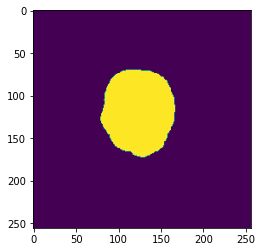

In [63]:
import numpy as np
from matplotlib import pyplot as plt
ret,thresh1 = cv2.threshold(first_pred,10,255,cv2.THRESH_BINARY)
plt.imshow(thresh1)

In [5]:
!ls /content/gdrive/My\ Drive/ISIC-2017-Org-Train-Data/ISIC-2017_Training_Data_Patch_Final/ | wc -l

78317


In [ ]:
!du -sh /content/gdrive/My\ Drive/ISIC-2017-Org-Train-Data/ISIC-2017_Training_Data_Patch_Final/